# PyTorch

To more conveniently use arrays in Python, we will use the PyTorch numerical computing framework. To install it, go to https://pytorch.org/get-started and follow the instructions for your system. Once we have PyTorch installed, we import `torch` to use PyTorch.

In [1]:
import torch
import torch.utils.data as data

Install the following if necessary.
* `matplotlib` for plotting. Install it using `pip install matplotlib`. Or `conda install matplotlib` if you prefer.
* `tqdm` has a stupid name but provides a nice progress bar. `pip install tqdm`

In [2]:
import matplotlib.pyplot as plt
import tqdm

## Messing with Tensors

The most important data structure in PyTorch is the `Tensor`, which is an array of numbers, all of the same type, usually some kind of floating-point number. In the machine learning community, such arrays are often called *tensors*, and I'll use that term from here on.

You can create `Tensors` by passing in Python `tuple`s or `list`s to the `tensor` function.

In [3]:
a = torch.tensor((1, 2, 3, 4))
b = torch.tensor((( 5,  6,  7,  8),
                  (-5, -6, -7, -8)))

All `Tensor`s have `shape`s. Here are their shapes.

In [4]:
a.shape, b.shape

(torch.Size([4]), torch.Size([2, 4]))

You can add, subtract, and negate `Tensors` using + and -.

In [5]:
a + a, a - a

(tensor([2, 4, 6, 8]), tensor([0, 0, 0, 0]))

Broadcasting is applied automatically where it's unambiguous. (Read the 2_math_review notebook if you are unsure what broadcasting does.)

In [6]:
a + b

tensor([[ 6,  8, 10, 12],
        [-4, -4, -4, -4]])

Matrix multiplication can be done using the `@` operator.

In [7]:
b @ a

tensor([ 70, -70])

Element-wise multiplication is automatically broadcasted.

In [8]:
a * b

tensor([[  5,  12,  21,  32],
        [ -5, -12, -21, -32]])

You can select elements or slices of `Tensor`s using`[index]`. This `index` can be a variety of things. I'll show you a few examples.

In [9]:
b[0, 0]

tensor(5)

In [10]:
index = (0, 0)
b[index]

tensor(5)

In [11]:
b[1, :]

tensor([-5, -6, -7, -8])

In [12]:
b[:, 1]

tensor([ 6, -6])

In [13]:
b[:, :2]

tensor([[ 5,  6],
        [-5, -6]])

See PyTorch's [Tensor indexing API](https://pytorch.org/cppdocs/notes/tensor_indexing.html) for more examples.

# Gradient descent

Gradient descent is an optimization method that adjusts the parameters of a differentiable function that captures some sort of "loss," or the error of an estimation, in order to optimize it. I'll demonstrate it through a regression task. Regression is predicting a real number or real array.

Suppose there were some function $f$ that maps real numbers to real numbers. That is, $f: \mathbb{R} \to \mathbb{R}$. Let's make an $f$ that is actually $e^x +$ some random noise.

In [14]:
def f(x: torch.Tensor) -> torch.Tensor:
    """
    :returns: e^x + some random noise
    """
    return torch.exp(x) + 0.1 * torch.randn(len(x))

But let's pretend we don't know what $f$ is. We only see some examples of $x$ mapped to $y$.

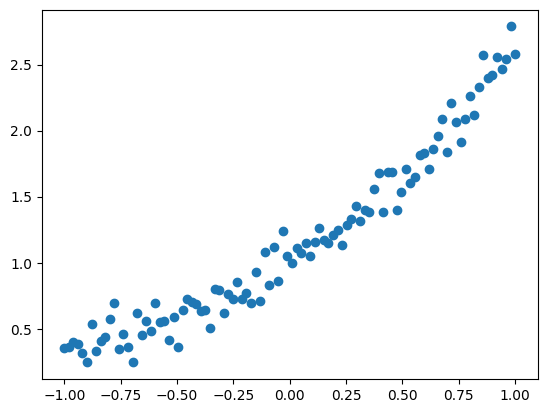

In [15]:
x = torch.linspace(-1, 1, 100)
y = f(x)
plt.scatter(x, y)
plt.show()

## Making a trainable function

We will attempt to approximate $f$ using a differentiable parameterized function $\hat{f}$ with much fewer parameters than the number of examples.

> Worth discussing with your friends: Why do we want much fewer parameters than the number of examples?

We will train parameters $\theta$ for $\hat{f}$ to minimize some differentiable loss function $L$ between $\hat{f}(x)$ and $y$ for all observations $(x, y)$.

We'll make a function such that we can repeatedly adjust $\theta$ against the gradient of $L$ with respect to $\theta$, at some learning rate $\lambda$. That is,

Do $\quad \theta \gets \theta - \lambda \nabla_\theta L(\hat{f}(X), \mathbf{y}) \quad$ repeatedly until it's good enough.

Typical artificial neural networks (ANNs) are functions that allow us to do that. Let's make one kind of ANN called a multilayer perceptron (MLP), also called a feedforward neural network, also called a fully connected neural network.

For now, let $\hat{f}$ be an MLP that takes a **single scalar** input $x$ and outputs a number $\hat{y}$. We will make it handle a batch of inputs later.

Here is what will happen inside.
1. We apply a linear transformation.
2. We apply a nonlinear transformation.
3. We apply a linear transformation.

For the **first linear transformation**, we will multiply $x$ by a vector of 4 weights $\mathbf{W_1}$, and then add a vector of 4 biases $\mathbf{B_1}$ to that. I've given these parameters the subscript $\mathbf{_1}$ because they belong to the 1st linear transformation. Both $\mathbf{W_1}$ and $\mathbf{B_1}$ will be shaped $4 \times 1$. Let's call the result $\mathbf{Z}$.

$\mathbf{Z} = \mathbf{W_1} x + \mathbf{B_1}$


Next, we apply a **nonlinear transformation** to $\mathbf{z}$. There are many we can choose from, but we usually use the rectified linear unit (ReLU). It's just a function that returns the max of 0 and the input.

$\mathrm{ReLU}(z) = \max(0, z)$

Let's apply it element-wise to $\mathbf{Z}$ and call the result $\mathbf{A}$ for "activation."

$\mathbf{A} = \mathrm{ReLU}(\mathbf{Z})$

Because machine learning (ML) people tend to use brain analogies, 4 elements in $\mathbf{A}$ are often called *neurons*, i.e. there are 4 neurons in this layer. They're also called *hidden units*.

Next, we apply the **second linear transformation**. $\mathbf{A}$ is a $4 \times 1$ matrix. Since we want a single-element output, we must multiply it by a $1 \times 4$ matrix $\mathbf{W_2}$ and then add a $1 \times 1$ matrix $\mathbf{B_2}$.

$\hat{y} = \mathbf{W_2 A} + \mathbf{B_2}$

## Batching

Batching is an essential component in modern machine learning because it allows us to train functions quickly by leveraging parallel multiprocessors, i.e. graphics processing units (GPUs).

Now suppose we want $\hat{f}$ to take a batch of inputs $\mathbf{X}$. We need to consider what shape $\mathbf{X}$ should be. The convention is to make the first dimension the batch dimension, followed by the shape of a single $x$. Since our $x$ is just a single number, our $\mathbf{X}$ is shaped $(\mathrm{batch\ size} \times 1)$. We also want $\hat{\mathbf{Y}}$, the batch of outputs from $\hat{f}$, to have the batch dimension first.

To do this, we transpose the $\mathbf{W}$ s, so that $\mathbf{W_1}$ is shaped $1 \times 4$ and $\mathbf{W_2}$ is shaped $4 \times 1$.

Then, we change $\hat{f}$ thus:
> Instead of multiplying $\mathbf{W_1}x$, we do $\mathbf{XW_1}$.

> Instead of multiplying $\mathbf{W_2 A}$, we do $\mathbf{AW_2}$.

Then $\hat{\mathbf{Y}}$ will be shaped $(\mathrm{batch\ size} \times 1)$. You can ponder about it and work out a few examples until you're convinced.

## Let's write it.

First, let's make sure $\mathbf{X}$ and $\mathbf{Y}$ are the shape we want.

In [16]:
x.shape, y.shape

(torch.Size([100]), torch.Size([100]))

Right now they're 1-dimensional arrays. We want to make them 2-dimensional by adding a second dimension of size 1.

In [17]:
x = x[:, None]
y = y[:, None]

Now check their shapes.

In [18]:
x.shape, y.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

We can then write $\hat{f}$.

First, write a linear function that returns $\mathbf{Z}$ from $x$. It should be about one line of code.

In [19]:
def linear1(x: torch.Tensor, w1: torch.Tensor, b1: torch.Tensor) -> torch.Tensor:
    """
    :returns: z

    I usually write better docstrings, but that would just give you the solution.
    """
    return x @ w1 + b1

Now implement the nonlinear function that returns $\mathbf{A}$. Take $\mathbf{Z}$ as input. One line.

In [20]:
def nonlinear(z: torch.Tensor) -> torch.Tensor:
    """
    :returns: a
    """
    return torch.relu(z)

Next, implement the second linear function that returns $\hat{y}$. Take $\mathbf{A}$ as input. One line.

In [21]:
def linear2(a: torch.Tensor, w2: torch.Tensor, b2: torch.Tensor) -> torch.Tensor:
    """
    :returns: y hat
    """
    return a @ w2 + b2

Finally, write $\hat{f}$ as a composition of the first linear, the nonlinear, and the second linear functions. Instead of just returning $\hat{y}$, we're going to also return $\mathbf{Z}$ and $\mathbf{A}$ so we can use them to calculate gradients later. This should take about 3 lines of code.

In [22]:
def f_hat(x: torch.Tensor, 
          w1: torch.Tensor, 
          b1: torch.Tensor,
          w2: torch.Tensor, 
          b2: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    :returns: a tuple (z, a, y hat)
    """
    z = linear1(x, w1, b1)
    a = nonlinear(z)
    return z, a, linear2(a, w2, b2)

This $\hat{f}$ function can handle inputs of a single $x$ or all of them as $\mathbf{X}$. We will also consider the corresponding set of all $y$ as $\mathbf{Y}$.

For our loss function, we can use the mean squared error $L = \text{MSE}(\hat{\mathbf{Y}}, \mathbf{Y}) = \dfrac{\sum_{i=1}^{|\mathbf{Y}|}(\hat{\mathbf{Y}_i} - \mathbf{Y}_i)^2}{|\mathbf{Y}|}$. I'll write this one for you.

In [23]:
def loss(y_hat: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    :param y_hat: predictions
    :param y: labels
    :returns: the mean squared error between y_hat and y.
    """
    return ((y_hat - y) ** 2).sum() / y.shape[0]

To recap,
> We wanted a differentiable parameterized function that had could approximate $f$. We now have this as $\hat{f}$.

> We also wanted a differentiable function that could capture the error between the output of $\hat{f}$ and the output of $f$. We now have this as $L$.

## Backpropagation

To know how to adjust the parameters, we must find the gradient of the loss function with respect to each parameter. Once we find that, we just nudge the parameters in a direction that decreases the loss. Because we can step backwards through the operations using the chain rule, this is called *backpropagation*, while applying $\hat{f}$ is called *forward propagation*.

Let's find the gradients from the back. In order to go from $L$ to all the parameters, we have to go through $\hat{y}$. What's $\nabla_{\hat{y}} L$?

In [24]:
def d_loss_wrt_y_hat(y_hat: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    :param y_hat: predictions
    :param y: labels
    :returns: the derivative of the loss with respect to the predictions.
    """
    return 2 * (y_hat - y)

Next, we have the $\mathbf{W_2}$ and $\mathbf{B_2}$ in our sights. I'll give you these.

In [25]:
def d_y_hat_wrt_w2(a: torch.Tensor) -> torch.Tensor:
    """
    :param a: output of the nonlinear function
    :returns: the derivative of the second linear function with respect to w2.
    """
    return a.sum(0)

def d_y_hat_wrt_b2() -> torch.Tensor:
    """
    :returns: the derivative of the second linear function with respect to b2.
    """
    return 1

Although $\mathbf{A}$ is not a parameter, we have to go through it in order to get to the other parameters.

In [26]:
def d_y_hat_wrt_a(w2: torch.Tensor) -> torch.Tensor:
    """
    :returns: the derivative of the second linear function with respect to a.
    """
    return w2.sum()

$\mathbf{A}$ was the output of the nonlinear function, i.e. ReLU. Although in pure math, ReLU is not differentiable, we treat its derivative as 1 if its input is greater than 0 and 0 otherwise.

In [27]:
def d_a_wrt_z(z: torch.Tensor) -> torch.Tensor:
    """
    :param z: the output of the first linear function
    :returns: the derivative of ReLU with respect to z
    """
    return z > 0

From $\mathbf{Z}$, we can see $\mathbf{W_1}$ and $\mathbf{B_1}$.

In [28]:
def d_z_wrt_w1(x: torch.Tensor) -> torch.Tensor:
    """
    :param x: input examples
    :returns: the derivative of the first linear function with respect to w1
    """
    return x.mean()

In [29]:
def d_z_wrt_b1() -> torch.Tensor:
    """
    :param x: input examples
    :returns: the derivative of the first linear function with respect to b1
    """
    return 1

With this information, we can repeatedly update

* $\mathbf{W_1} \gets \mathbf{W_1} - \eta \nabla_{\mathbf{W_1}} L$
* $\mathbf{B_1} \gets \mathbf{B_1} - \eta \nabla_{\mathbf{B_1}} L$
* $\mathbf{W_2} \gets \mathbf{W_2} - \eta \nabla_{\mathbf{W_2}} L$
* $\mathbf{B_2} \gets \mathbf{B_2} - \eta \nabla_{\mathbf{B_2}} L$

until we approach the capability of $\hat{f}$ to approximate $f$. In practice, we'll decide a number of epochs to train.

Now we can write the gradient descent function. We will first initialize the parameters: the $\mathbf{W}$ s randomly and the $\mathbf{B}$ s to $\mathbf{0}$. Then start a loop for a number of epochs, applying the updates to these parameters each time.

In [40]:
N_EPOCHS = 10000
LEARNING_RATE = 0.001
N_HIDDEN_UNITS = 4

w1 = torch.randn(1, N_HIDDEN_UNITS)
b1 = torch.zeros(N_HIDDEN_UNITS)
w2 = torch.randn(N_HIDDEN_UNITS, 1)
b2 = torch.zeros(1)

def gradient_descent(w1: torch.Tensor, 
                     b1: torch.Tensor, 
                     w2: torch.Tensor, 
                     b2: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Probably the most influential algorithm in your lifetime.
    """
    w1 = torch.randn(1, N_HIDDEN_UNITS)
    b1 = torch.zeros(N_HIDDEN_UNITS)
    w2 = torch.randn(N_HIDDEN_UNITS, 1)
    b2 = torch.zeros(1)
    
    for _ in (progress_bar := tqdm.tqdm(range(N_EPOCHS), desc="training")):
        z, a, y_hat = f_hat(x, w1, b1, w2, b2)
        batch_loss = loss(y_hat, y)

        d_loss_wrt_w2 = (d_loss_wrt_y_hat(y_hat, y) * d_y_hat_wrt_w2(a)).mean(0)
        d_loss_wrt_b2 = (d_loss_wrt_y_hat(y_hat, y) * d_y_hat_wrt_b2()).mean(0)
        d_loss_wrt_w1 = (d_loss_wrt_y_hat(y_hat, y) * d_y_hat_wrt_a(w2) * d_a_wrt_z(z) * d_z_wrt_w1(x)).mean(0)
        d_loss_wrt_b1 = (d_loss_wrt_y_hat(y_hat, y) * d_y_hat_wrt_a(w2) * d_a_wrt_z(z) * d_z_wrt_b1()).mean(0)

        w2 -= LEARNING_RATE * d_loss_wrt_w2[:, None]
        b2 -= LEARNING_RATE * d_loss_wrt_b2
        w1 -= LEARNING_RATE * d_loss_wrt_w1[None, :]
        b1 -= LEARNING_RATE * d_loss_wrt_b1

        progress_bar.set_postfix_str(f"batch loss: {batch_loss}")

    return w1, b1, w2, b2

With just random parameters, $\hat{f}$ shouldn't be good at approximating $f$.

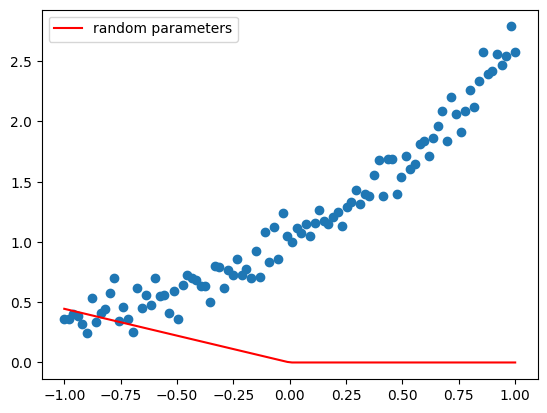

In [41]:
plt.clf()
plt.scatter(x.cpu().numpy(), y)
plt.plot(x.cpu().numpy(), 
         f_hat(x, w1, b1, w2, b2)[2].cpu().numpy(), 
         color="red", 
         label="random parameters")
plt.legend()
plt.show()

In [42]:
w1, b1, w2, b2 = gradient_descent(w1, b1, w2, b2)

training: 100%|██████████| 10000/10000 [00:04<00:00, 2419.91it/s, batch loss: 0.013766736723482609]


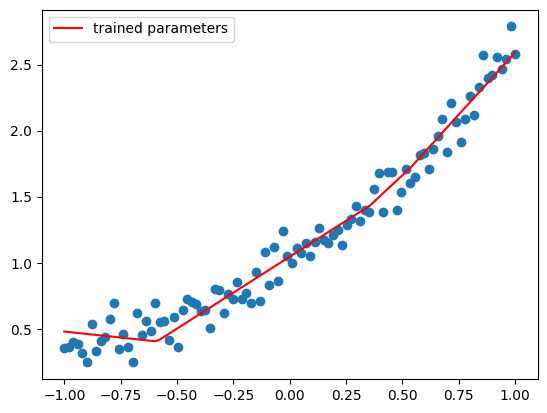

In [43]:
plt.clf()
plt.scatter(x.cpu().numpy(), y)
plt.plot(x.cpu().numpy(), 
         f_hat(x, w1, b1, w2, b2)[2].cpu().numpy(), 
         color="red", 
         label="trained parameters")
plt.legend()
plt.show()

# Stochastic gradient descent

Stochastic gradient descent (SGD) is just gradient descent, but instead of updating parameters after looking at all examples, you update them after looking at a smaller batch of them, called a minibatch, or just a batch. This may be necessary when all training data can't fit into your memory. An epoch is counted when you look at all examples once.

Suppose we use minibatches of size 32.

In [44]:
BATCH_SIZE = 32

When training with SGD, you should shuffle your training data, just in case there's some order to them that would cause weird training behavior. The PyTorch way to do this is to create a PyTorch `Dataset` out of the data, and load it into your training loop with a `DataLoader`, which takes care of shuffling it every epoch.

In [45]:
dataloader = data.DataLoader(data.TensorDataset(x, y), batch_size=BATCH_SIZE, shuffle=True)

In [50]:
def stochastic_gradient_descent(
        w1: torch.Tensor, 
        b1: torch.Tensor, 
        w2: torch.Tensor, 
        b2: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Probably the most influential algorithm in your lifetime.
    """
    w1 = torch.randn(1, N_HIDDEN_UNITS)
    b1 = torch.zeros(N_HIDDEN_UNITS)
    w2 = torch.randn(N_HIDDEN_UNITS, 1)
    b2 = torch.zeros(1)
    
    for _ in (progress_bar := tqdm.tqdm(range(N_EPOCHS), desc="training")):
        for x, y in dataloader:
            z, a, y_hat = f_hat(x, w1, b1, w2, b2)
            batch_loss = loss(y_hat, y)

            d_loss_wrt_w2 = (d_loss_wrt_y_hat(y_hat, y) * d_y_hat_wrt_w2(a)).mean(0)
            d_loss_wrt_b2 = (d_loss_wrt_y_hat(y_hat, y) * d_y_hat_wrt_b2()).mean(0)
            d_loss_wrt_w1 = (d_loss_wrt_y_hat(y_hat, y) * d_y_hat_wrt_a(w2) * d_a_wrt_z(z) * d_z_wrt_w1(x)).mean(0)
            d_loss_wrt_b1 = (d_loss_wrt_y_hat(y_hat, y) * d_y_hat_wrt_a(w2) * d_a_wrt_z(z) * d_z_wrt_b1()).mean(0)

            w2 -= LEARNING_RATE * d_loss_wrt_w2[:, None]
            b2 -= LEARNING_RATE * d_loss_wrt_b2
            w1 -= LEARNING_RATE * d_loss_wrt_w1[None, :]
            b1 -= LEARNING_RATE * d_loss_wrt_b1

            progress_bar.set_postfix_str(f"minibatch loss: {batch_loss}")

    return w1, b1, w2, b2

Let's reinitialize the parameters and try it out.

In [51]:
w1 = torch.randn(1, N_HIDDEN_UNITS)
b1 = torch.zeros(N_HIDDEN_UNITS)
w2 = torch.randn(N_HIDDEN_UNITS, 1)
b2 = torch.zeros(1)

w1, b1, w2, b2 = stochastic_gradient_descent(w1, b1, w2, b2)

training: 100%|██████████| 10000/10000 [00:22<00:00, 444.66it/s, minibatch loss: 0.005174205172806978] 


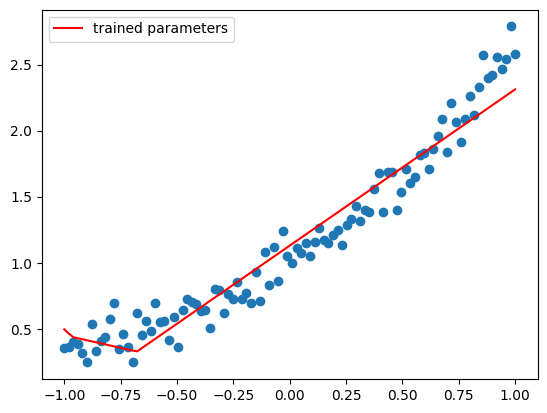

In [52]:
plt.clf()
plt.scatter(x.cpu().numpy(), y)
plt.plot(x.cpu().numpy(), 
         f_hat(x, w1, b1, w2, b2)[2].cpu().numpy(), 
         color="red", 
         label="trained parameters")
plt.legend()
plt.show()